In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data 
import torch.nn.functional as F

import matplotlib.pyplot as plt
import csv


In [2]:
class RBM():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        # bias for hidden nodes
        self.a = torch.randn(1, nh)
        # bias for visible nodes
        self.b = torch.randn(1, nv)

    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train(self, v0, vk, ph0, phk):
        self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)
        
    def predict(self, x): # x: visible nodes
        _, h = self.sample_h( x)
        _, v = self.sample_v( h)
        return v

In [3]:
ratings_data = pd.read_csv('/kaggle/input/the-movies-dataset/ratings.csv')
movies_data = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv', engine='python')



In [4]:
movies_data = movies_data.dropna()
movies_data = movies_data.drop_duplicates()
movies_data = movies_data.reset_index(drop=True)

In [5]:
import ast
movies_data['genres'] = movies_data['genres'].apply(ast.literal_eval)
movies_data['Genre'] = movies_data['genres'].apply(lambda x: [item['name'] for item in x])
movies = movies_data[['id', 'title', 'Genre']]
movies.head()



,id,title,Genre
0,710,GoldenEye,"[Adventure, Action, Thriller]"
1,10634,Friday,[Comedy]
2,755,From Dusk Till Dawn,"[Horror, Action, Thriller, Crime]"
3,5894,Blue in the Face,[Comedy]
4,9070,Mighty Morphin Power Rangers: The Movie,"[Action, Adventure, Science Fiction, Family, F..."


In [6]:
movies = movies.rename(columns={'id': 'movieId'})
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


Our data is ready now, we are using ratings_data and movies

In [9]:
print("shape of movie dataset: ",movies_sorted.shape)
print("shape of rating dataset: ",ratings_data.shape)

shape of movie dataset:  (693, 4)
shape of rating dataset:  (26024289, 4)


In [8]:
movies_sorted = movies.sort_values(by='movieId')
movies_sorted = movies_sorted.reset_index(drop=True)
movies_sorted['List Index'] = movies_sorted.index
movies_sorted.head()

,movieId,title,Genre,List Index
0,10005,Behind Enemy Lines II: Axis of Evil,"[Action, Adventure, Thriller]",0
1,10009,Brother Bear,"[Adventure, Animation, Family]",1
2,100183,Outpost: Black Sun,"[Action, Horror]",2
3,10020,Beauty and the Beast,"[Romance, Family, Animation, Fantasy, Music]",3
4,10032,Van Wilder 2: The Rise of Taj,[Comedy],4


In [10]:
movies_sorted.dtypes
#ratings_data.dtypes

movieId       object
title         object
Genre         object
List Index     int64
dtype: object

In [11]:
movies_sorted["movieId"] = movies["movieId"].astype("int64")
#Merging movies_df with ratings_df by MovieID
merged_data = movies_sorted.merge(ratings_data, on='movieId')
#Dropping unecessary columns
merged_data = merged_data.drop('timestamp', axis=1).drop('title', axis=1).drop('Genre', axis=1)
#Displaying the result
merged_data.head()

,movieId,List Index,userId,rating
0,710,0,619,3.0
1,710,0,1932,2.0
2,710,0,2073,4.0
3,710,0,2260,3.0
4,710,0,2680,3.0


In [12]:
print(merged_data.shape)
#Grouping up by UserID
userGroup = merged_data.groupby('userId')
userGroup.first().head()

(805797, 4)


,movieId,List Index,rating
userId,,,
1,1246,193,5.0
2,58,183,3.0
6,11,6,3.0
8,585,100,2.0
9,1246,193,4.5


In [13]:
movies_data_numeric = movies_sorted.select_dtypes(include=[np.number])
#Training set
#Amount of users used for training
amountOfUsedUsers = 1000
train_X = []

for userID, curUser in userGroup:
    temp = [0]*len(movies_data_numeric)
    for num, movie in curUser.iterrows():
        temp[int(movie['List Index'])] = movie['rating']/5.0
    train_X.append(temp)
    #Check to see if we finished adding in the amount of users for training
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

In [14]:
#print(W.shape, hb.shape, vb.shape)
print(len(train_X[0]))
len(movies_data_numeric)

693


693

In [23]:
hidden_units = 20
visible_units = len(movies_data_numeric)

vb = torch.zeros(visible_units, requires_grad=True, dtype=float)
hb = torch.zeros(hidden_units, requires_grad=True, dtype=float)
W = torch.randn(visible_units, hidden_units, requires_grad=True, dtype=float)

In [24]:

# Phase 1: Input Processing
v0 = torch.zeros((0, visible_units), dtype=torch.float32, requires_grad = True)
_h0 = torch.sigmoid(torch.matmul(v0, W) + hb)
h0 = torch.relu(torch.sign(_h0 - torch.rand_like(_h0)))

# Phase 2: Reconstruction
_v1 = torch.sigmoid(torch.matmul(h0, W.t()) + vb)
v1 = torch.relu(torch.sign(_v1 - torch.rand_like(_v1)))
h1 = torch.sigmoid(torch.matmul(v1, W) + hb)

In [25]:
v0.shape, v1.shape

(torch.Size([0, 693]), torch.Size([0, 693]))

In [26]:
## TRAINING PARAMETERS

# Learning rate
alpha = 1.0

# Calculate the Contrastive Divergence to maximize
w_pos_grad = torch.matmul(v0.t(), h0)
w_neg_grad = torch.matmul(v1.t(), h1)
CD = (w_pos_grad - w_neg_grad) / v0.size(0)

# Update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * torch.mean(v0 - v1, dim=0)
update_hb = hb + alpha * torch.mean(h0 - h1, dim=0)

# Reconstruction error
err = v0 - v1
err_sum = torch.mean(err * err).item()

In [27]:
#error function
err = v0 - v1
err_sum = torch.mean(err * err).item()

In [28]:
# Current weights and biases
cur_w = np.zeros([visible_units, hidden_units], np.float32)
cur_vb = np.zeros([visible_units], np.float32)
cur_hb = np.zeros([hidden_units], np.float32)

# Previous weights and biases
prv_w = np.zeros([visible_units, hidden_units], np.float32)
prv_vb = np.zeros([visible_units], np.float32)
prv_hb = np.zeros([hidden_units], np.float32)

/tmp/ipykernel_48/3380664585.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = torch.tensor(train_X, dtype=torch.float32)


Epoch 1, Reconstruction Error: 0.0011665284213774481
Epoch 2, Reconstruction Error: 0.00012581156263175825
Epoch 3, Reconstruction Error: 8.388523500931774e-05
Epoch 4, Reconstruction Error: 7.556455137701917e-05
Epoch 5, Reconstruction Error: 7.21913012412855e-05
Epoch 6, Reconstruction Error: 7.095444284077646e-05
Epoch 7, Reconstruction Error: 6.988768854187592e-05
Epoch 8, Reconstruction Error: 6.794446583408238e-05
Epoch 9, Reconstruction Error: 6.819241412865147e-05
Epoch 10, Reconstruction Error: 6.790986838047613e-05
Epoch 11, Reconstruction Error: 6.794446582097901e-05
Epoch 12, Reconstruction Error: 6.72611664470355e-05
Epoch 13, Reconstruction Error: 6.693825702647198e-05
Epoch 14, Reconstruction Error: 6.720638716829781e-05
Epoch 15, Reconstruction Error: 6.736784185527277e-05


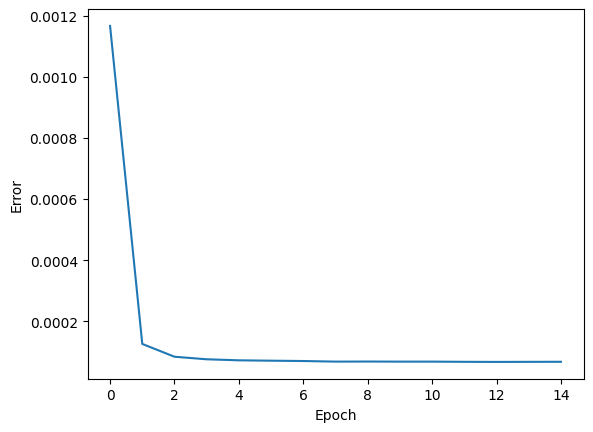

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Assuming train_X is a PyTorch tensor
train_X = torch.tensor(train_X, dtype=torch.float32)

# Assuming you have defined your RBM parameters (W, vb, hb) as described before

epochs = 15
batch_size = 100
errors = []

for epoch in range(epochs):
    train_loss = 0
    s = 0
    for start, end in zip(range(0, len(train_X), batch_size), range(batch_size, len(train_X), batch_size)):
        batch = train_X[start:end]

        # Forward pass
        #print(batch.dtype, W.dtype)
        batch = batch.to(W.t().dtype)
        _h0 = torch.sigmoid(F.linear(batch, W.t(), hb))
        h0 = torch.relu(torch.sign(_h0 - torch.rand_like(_h0)))
        _v1 = torch.sigmoid(F.linear(h0, W, vb))
        v1 = torch.relu(torch.sign(_v1 - torch.rand_like(_v1)))
        h1 = torch.sigmoid(F.linear(v1, W.t(), hb))

        # Calculate Contrastive Divergence
        w_pos_grad = torch.matmul(batch.t(), h0)
        w_neg_grad = torch.matmul(v1.t(), h1)
        CD = (w_pos_grad - w_neg_grad) / batch.size(0)

        # Update parameters
        W.data += CD * alpha
        vb.data += torch.mean(batch - v1, dim=0) * alpha
        hb.data += torch.mean(h0 - h1, dim=0) * alpha
        
        train_loss += torch.mean((batch-v1)**2).item()

    # Calculate reconstruction error
    #err = torch.sigmoid(torch.matmul(batch, W.t()) + vb)
    err_sum = train_loss/len(train_X)
    errors.append(err_sum)
    print(f'Epoch {epoch + 1}, Reconstruction Error: {err_sum}')

# Plot the errors
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()


RECOMMENDATION

In [30]:
#Selecting the input user
inputUser = [train_X[75]]

In [31]:
user_input = train_X[75]  # User's preferences (PyTorch tensor)

# Convert NumPy arrays to PyTorch tensors
user_input = torch.tensor(user_input, dtype=torch.float32)
prv_w = torch.tensor(prv_w, dtype=torch.float32)
prv_hb = torch.tensor(prv_hb, dtype=torch.float32)
prv_vb = torch.tensor(prv_vb, dtype=torch.float32)

# Encode user preferences
user_hidden_activations = torch.sigmoid(F.linear(user_input, prv_w.t(), prv_hb))

# Reconstruct the visible layer (recommended items)
recommended_items = torch.sigmoid(F.linear(user_hidden_activations, prv_w, prv_vb))

# Rank items based on reconstructed probabilities
ranked_recommendations, indices = recommended_items.sort(descending=True)

indices
#ranked_recommendations
# Select the top-5 recommendations
#top_5_recommendations = indices[]

/tmp/ipykernel_48/3146736535.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_input = torch.tensor(user_input, dtype=torch.float32)


tensor([466, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 455, 467, 468,
        469, 470, 471, 472, 473, 474, 475, 476, 444, 434, 435, 436, 437, 438,
        439, 440, 441, 442, 443, 477, 445, 446, 447, 448, 449, 450, 451, 452,
        453, 454, 509, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 498,
        510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 488, 478, 479, 480,
        481, 482, 483, 484, 485, 486, 487, 433, 489, 490, 491, 492, 493, 494,
        495, 496, 497, 379, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
        368, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 357, 347, 348,
        349, 350, 351, 352, 353, 354, 355, 356, 390, 358, 359, 360, 361, 362,
        363, 364, 365, 366, 367, 422, 412, 413, 414, 415, 416, 417, 418, 419,
        420, 421, 411, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 401,
        391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 520, 402, 403, 404,
        405, 406, 407, 408, 409, 410, 639, 629, 630, 631, 632, 6